In [1]:
# cv_analysis.ipynb

import json
import os
import sys
from pathlib import Path
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader

PROJECT_ROOT = Path("..").resolve()

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from src.data.dataloader import (
    ForgeryDataset,
    detection_collate_fn,
    get_val_transform,
)
from src.models.mask2former_v1 import Mask2FormerForgeryModel
from src.utils.config_utils import load_yaml, sanitize_model_kwargs
from src.training.train_cv import build_solution_df
from src.data.dataloader import ForgeryDataset
from src.models.kaggle_metric import score as kaggle_score

plt.style.use("ggplot")

In [2]:
# -----------------
# Constants / Paths
# -----------------

OOF_ROOT = PROJECT_ROOT / "experiments" / "oof_results"
FULL_TRAIN_ROOT = PROJECT_ROOT / "experiments" / "full_train_results"

CLS_THRESHOLD_PATH = (
    PROJECT_ROOT / "experiments" / "cls_threshold_sweep" / "cls_threshold_sweep.csv"
)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CFG_PATH = PROJECT_ROOT / "config" / "base.yaml"

CLPSE_ROOT = PROJECT_ROOT / "experiments" / "cls_collapse"

SAMPLEDUMP_ROOT = PROJECT_ROOT / "experiments" / "oof_results"

### OOF CV results

In [3]:
# List what's in experiments/oof_results/
oof_items = list(OOF_ROOT.iterdir())
oof_dirs = sorted([p.name for p in oof_items if p.is_dir()])
oof_files = sorted([p.name for p in oof_items if p.is_file()])

print("OOF dirs:", oof_dirs)
if oof_files:
    print("OOF loose files:", oof_files)


OOF dirs: ['anti_collapse_wcls2_strong_auth_penalty', 'balanced_soft_penalty_thr0p3_temp0p3', 'base_wgroupkfold', 'cls_unclamp_test', 'gate_pass_TRUE', 'inf_thresh_off', 'loss_dice_heavy_bce0p5_dice2', 'mask_first_wmask4_wcls0p25', 'match_bce_dominant_cost2_dice0p5', 'match_dice_dominant_cost2_bce0p5', 'mini_smoke', 'sharp_auth_penalty_temp0p05_thr0p6_w2', 'soft_auth_penalty_temp1_thr0p2_w3']
OOF loose files: ['sanity_random_200.csv']


In [101]:
def load_run(names):
    """
    names:
      - str: dir name under OOF_ROOT OR filename under OOF_ROOT
      - list/tuple[str]: load multiple; returns dict keyed by run/filename
    """
    if isinstance(names, (list, tuple)):
        return {str(n): load_run(str(n)) for n in names}

    name = str(names)
    p = OOF_ROOT / name

    # Case A: run directory
    if p.is_dir():
        run_dir = p
        oof_csv = run_dir / "oof_predictions.csv"
        metrics_json = run_dir / "oof_metrics.json"

        oof_df = pd.read_csv(oof_csv) if oof_csv.exists() else None
        metrics = json.load(metrics_json.open()) if metrics_json.exists() else None

        fold_files = sorted(run_dir.glob("fold_*_oof.csv"))
        fold_dfs = {f.stem: pd.read_csv(f) for f in fold_files}

        return {"name": run_dir.name, "path": run_dir, "oof": oof_df, "metrics": metrics, "folds": fold_dfs}

    # Case B: loose file
    if p.is_file():
        if p.suffix.lower() == ".csv":
            return {"name": p.name, "path": p, "oof": pd.read_csv(p), "metrics": None, "folds": {}}
        if p.suffix.lower() == ".json":
            return {"name": p.name, "path": p, "oof": None, "metrics": json.load(p.open()), "folds": {}}
        raise ValueError(f"Unsupported file type: {p.suffix}")

    raise FileNotFoundError(f"Not found under OOF_ROOT: {name}")

# Use load_run(name | [names]) to load one or more CV runs or loose files from experiments/oof_results/
runs = load_run(["sharp_auth_penalty_temp0p05_thr0p6_w2"])  # or: load_run("mini_smoke"), load_run("oof_predictions.csv")

print("Loaded:")
if isinstance(runs, dict) and "name" not in runs:
    for k, v in runs.items():
        print(f" - {v['name']} ({v['path']})")
else:
    print(f" - {runs['name']} ({runs['path']})")



Loaded:
 - sharp_auth_penalty_temp0p05_thr0p6_w2 (C:\Users\piiop\Desktop\Portfolio\Projects\RecodAI_LUC\experiments\oof_results\sharp_auth_penalty_temp0p05_thr0p6_w2)


=== Loaded runs ===

sharp_auth_penalty_temp0p05_thr0p6_w2
  Mean CV   : 0.053382863963528086
  OOF score : 0.05338264970685973
  Folds     : [0.0522738714481377, 0.054225164098428584, 0.05364955634401796]


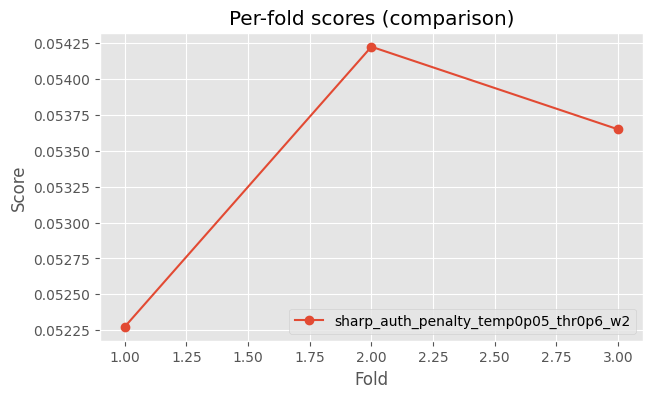

In [102]:
def show_run_metrics(names):
    """
    Pass a run dir name (str) or list of names to compare.
    """
    runs = load_run(names)
    if isinstance(runs, dict) and "name" not in runs:
        items = list(runs.values())
    else:
        items = [runs]

    # Clean summary header
    print("=== Loaded runs ===")
    for r in items:
        m = r["metrics"] or {}
        mean_cv = m.get("mean_cv", None)
        oof_score = m.get("oof_score", None)
        fold_scores = m.get("fold_scores", None)

        print(f"\n{r['name']}")
        print(f"  Mean CV   : {mean_cv}")
        print(f"  OOF score : {oof_score}")
        if fold_scores is not None:
            print(f"  Folds     : {fold_scores}")

    # Comparison plot (only for runs that have fold_scores)
    plot_items = [(r["name"], (r["metrics"] or {}).get("fold_scores")) for r in items]
    plot_items = [(n, fs) for (n, fs) in plot_items if fs is not None]

    if plot_items:
        plt.figure(figsize=(7, 4))
        for name, fs in plot_items:
            plt.plot(range(1, len(fs) + 1), fs, marker="o", label=name)
        plt.xlabel("Fold")
        plt.ylabel("Score")
        plt.title("Per-fold scores (comparison)")
        plt.legend()
        plt.show()

    return runs

# Single run
_ = show_run_metrics("sharp_auth_penalty_temp0p05_thr0p6_w2")

# Compare multiple runs
# _ = show_run_metrics(["mini_smoke", "some_other_run"])



## CollapseLogger

In [103]:
# ---- Use an already-loaded run from `runs` ----
run = runs["sharp_auth_penalty_temp0p05_thr0p6_w2"]  # must exist in `runs`

OOF_RUN_DIR = Path(run["path"])
oof_metrics = run["metrics"] or {}
oof_predictions = run["oof"]
fold_dfs = run["folds"]

print("\n== oof_predictions.csv (head) ==")
display(oof_predictions.head() if oof_predictions is not None else None)

print("\nFound fold CSVs:", list(fold_dfs.keys()))


== oof_predictions.csv (head) ==


,row_id,annotation
0,10,"[1, 331776]"
1,10015,"[1, 1920000]"
2,10017,"[1, 81920]"
3,10030,"[1, 666000]"
4,10070,"[1, 294768]"



Found fold CSVs: ['fold_1_oof', 'fold_2_oof', 'fold_3_oof']


In [16]:
# Rebuild solution_df and re-score to match train_cv additional pipeline verification
full_dataset = ForgeryDataset(transform=None)
solution_df = build_solution_df(full_dataset)

# Overall OOF score (ALIGN BY row_id, then score)
solution_df["row_id"] = solution_df["row_id"].astype(str)
oof_predictions["row_id"] = oof_predictions["row_id"].astype(str)

sub_aligned = (
    solution_df[["row_id"]]
    .merge(oof_predictions[["row_id", "annotation"]], on="row_id", how="left")
)

recomputed_oof = kaggle_score(
    solution_df[["row_id", "annotation", "shape"]].copy(),
    sub_aligned[["row_id", "annotation"]].copy(),
    row_id_column_name="row_id",
)

print("\n== Recomputed overall OOF score ==")
print("recomputed_oof:", float(recomputed_oof))

# Per-fold (recompute using the saved fold CSVs if present)
def fold_num_from_stem(stem: str) -> int:
    m = re.search(r"(\d+)", stem)
    return int(m.group(1)) if m else -1

if fold_dfs:
    # Build stable (row_id, occ) keys on the FULL solution_df once
    sol = solution_df.copy()
    sol["row_id"] = sol["row_id"].astype(str)
    sol["occ"] = sol.groupby("row_id").cumcount()

    fold_scores = []
    for stem, fdf in sorted(fold_dfs.items(), key=lambda kv: fold_num_from_stem(kv[0])):
        fnum = fold_num_from_stem(stem)

        sub = fdf.copy()
        sub["row_id"] = sub["row_id"].astype(str)
        # IMPORTANT: occ must follow the fold CSV order (this is what we’ll score)
        sub["occ"] = sub.groupby("row_id").cumcount()

        # Rebuild fold solution IN THE SAME ORDER AS sub (no sorting, no isin)
        fold_sol = sub[["row_id", "occ"]].merge(
            sol[["row_id", "occ", "annotation", "shape"]],
            on=["row_id", "occ"],
            how="left",
        )

        # Hard sanity checks (if these fail, your saved fold CSV isn't compatible with solution_df)
        assert len(fold_sol) == len(sub)
        if fold_sol["annotation"].isna().any() or fold_sol["shape"].isna().any():
            bad = fold_sol[fold_sol["annotation"].isna() | fold_sol["shape"].isna()].head(10)
            raise RuntimeError(f"{stem}: fold_sol has missing GT rows. Sample:\n{bad}")

        # Submission already in correct order; kaggle_score aligns by row order
        fold_sub = sub[["row_id", "annotation"]].copy()

        s = kaggle_score(
            fold_sol[["row_id", "annotation", "shape"]].copy(),
            fold_sub.copy(),
            row_id_column_name="row_id",
        )
        fold_scores.append((fnum, float(s)))

    fold_scores_df = pd.DataFrame(fold_scores, columns=["fold", "kaggle_metric"]).sort_values("fold")
    print("\n== Recomputed per-fold scores ==")
    display(fold_scores_df)

KeyboardInterrupt: 

In [104]:
# ---------------------------------------------------------------------
# Load ClsCollapseLogger outputs for the CV folds
# (stored under experiments/oof_results/<run_name>/cv_fold*/ and cv_oof_summary/)
# ---------------------------------------------------------------------

def _read_json(p: Path):
    with open(p, "r") as f:
        return json.load(f)

def _read_jsonl(p: Path):
    rows = []
    with open(p, "r") as f:
        for line in f:
            line = line.strip()
            if line:
                rows.append(json.loads(line))
    return pd.DataFrame(rows) if rows else pd.DataFrame()

def _read_table(p: Path):
    suf = p.suffix.lower()
    if suf == ".csv":
        return pd.read_csv(p)
    if suf in (".jsonl", ".ndjson"):
        return _read_jsonl(p)
    return None

LOGGER_FILES = {
    "debug.jsonl",
    "epoch_summary.csv",
    "meta.json",
    "optimizer.json",
    "step_losses.csv",
}

# Discover fold directories (cv_fold1, cv_fold2, ...) + optional cv_oof_summary
fold_dirs = []
if OOF_RUN_DIR.exists():
    for d in sorted(OOF_RUN_DIR.iterdir()):
        if d.is_dir() and (re.match(r"cv_fold\d+$", d.name) or d.name == "cv_oof_summary"):
            fold_dirs.append(d)

collapse_json = {}    # (fold_dirname, filename) -> dict
collapse_tables = {}  # (fold_dirname, filename) -> df

for d in fold_dirs:
    for fname in LOGGER_FILES:
        p = d / fname
        if not p.exists():
            continue

        if p.suffix.lower() == ".json":
            try:
                collapse_json[(d.name, fname)] = _read_json(p)
            except Exception:
                pass
        elif p.suffix.lower() in (".csv", ".jsonl", ".ndjson"):
            try:
                df = _read_table(p)
                if df is not None and len(df) > 0:
                    collapse_tables[(d.name, fname)] = df
            except Exception:
                pass

print("Loaded ClsCollapseLogger artifacts from:")
for d in fold_dirs:
    print(" ", d)

print(f"  JSON blobs : {len(collapse_json)}")
print(f"  Tables     : {len(collapse_tables)}")

if collapse_tables:
    by_dir = {}
    for (dname, fname), df in collapse_tables.items():
        by_dir.setdefault(dname, []).append((fname, df))

    for dname in sorted(by_dir):
        print(f"\n{dname} tables:")
        for fname, df in sorted(by_dir[dname], key=lambda x: x[0]):
            print(f"  - {fname} | shape={df.shape} | cols={list(df.columns)}")


Loaded ClsCollapseLogger artifacts from:
  C:\Users\piiop\Desktop\Portfolio\Projects\RecodAI_LUC\experiments\oof_results\sharp_auth_penalty_temp0p05_thr0p6_w2\cv_fold1
  C:\Users\piiop\Desktop\Portfolio\Projects\RecodAI_LUC\experiments\oof_results\sharp_auth_penalty_temp0p05_thr0p6_w2\cv_fold2
  C:\Users\piiop\Desktop\Portfolio\Projects\RecodAI_LUC\experiments\oof_results\sharp_auth_penalty_temp0p05_thr0p6_w2\cv_fold3
  C:\Users\piiop\Desktop\Portfolio\Projects\RecodAI_LUC\experiments\oof_results\sharp_auth_penalty_temp0p05_thr0p6_w2\cv_oof_summary
  JSON blobs : 6
  Tables     : 10

cv_fold1 tables:
  - debug.jsonl | shape=(224304, 53) | cols=['tag', 'fold', 'epoch', 'global_step', 'img_label', 'masks_shape', 'masks_sum', 'per_image', 'mask_probs', 'class_probs', 'img_probs', 'b', 'Q', 'Hm', 'Wm', 'tgt_shape', 'tgt_numel', 'tgt_sum', 'cost_shape', 'matched', 'num_gt', 'reason', 'B', 'pos', 'total', 'pos_frac', 'fg_prob_per_query', 'fg_prob_mean', 'fg_prob_p95', 'fg_prob_max', 'presenc

In [105]:
# TODO: Doublecheck this works with new organization
# Convenience: key summaries across ALL loaded debug tables

def concat_tables(name_contains: str):
    dfs = []
    for (fold_key, fname), df in collapse_tables.items():
        if name_contains.lower() in fname.lower():
            d = df.copy()
            m = re.search(r"(\d+)", str(fold_key))
            d["fold"] = int(m.group(1)) if m else fold_key  # cv_oof_summary stays as string
            d["_source"] = fname
            dfs.append(d)
    return pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()


step_losses = concat_tables("step")
epoch_summary = concat_tables("epoch")
debug_events = concat_tables("debug")

if len(step_losses):
    display(step_losses.describe(include="all"))


,fold,epoch,global_step,lr,loss_mask_bce,loss_mask_dice,loss_mask_cls,loss_img_auth,loss_auth_penalty,loss_total,w_mask_cls,w_auth_penalty,_source
count,51780.000000,51780.000000,51780.000000,5.178000e+04,51780.000000,51780.000000,51780.000000,51780.000000,5.178000e+04,51780.000000,51780.0,51780.0,51780
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,step_losses.csv
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51780
mean,2.000000,10.500000,8629.500000,1.000000e-04,0.142773,0.604592,0.265019,0.482184,1.744221e-03,1.838694,1.0,1.0,NaN
std,0.816504,5.766337,4982.580928,2.710532e-20,0.281945,0.225888,0.087733,0.257507,8.572720e-03,0.595560,0.0,0.0,NaN
min,1.000000,1.000000,0.000000,1.000000e-04,-0.000000,-0.000000,0.008853,0.000177,0.000000e+00,0.041999,1.0,1.0,NaN
25%,1.000000,5.750000,4314.750000,1.000000e-04,0.051584,0.472486,0.203678,0.302671,2.036030e-16,1.496382,1.0,1.0,NaN
50%,2.000000,10.500000,8629.500000,1.000000e-04,0.103695,0.619332,0.261321,0.463202,3.067504e-10,1.835138,1.0,1.0,NaN
75%,3.000000,15.250000,12944.250000,1.000000e-04,0.180686,0.763454,0.321237,0.643353,6.461942e-07,2.160837,1.0,1.0,NaN


In [106]:
# --- Useful, compact diagnostics for epoch_summary ---

es = epoch_summary.copy()

num_cols = [
    "epoch_loss", "cls_max_mean", "cls_max_p95",
    "keep_rate@0.1", "keep_rate@0.2", "keep_rate@0.3",
    "img_forged_mean", "mask_max_mean", "w_mask_cls",
]
for c in num_cols:
    es[c] = pd.to_numeric(es[c], errors="coerce")

last_epoch = (
    es.sort_values(["fold", "epoch"])
      .groupby("fold", as_index=False)
      .tail(1)
      .sort_values("fold")
)

# Per-fold last-epoch snapshot
display(
    last_epoch[["fold", "epoch"] + num_cols]
      .sort_values("fold")
      .reset_index(drop=True)
)

# Cross-fold mean/std at last epoch
agg = last_epoch[num_cols].agg(["mean", "std"]).T
agg.columns = ["mean", "std"]
display(agg.sort_values("mean"))

# Quick red-flag table at last epoch
flags = last_epoch.assign(
    cls_dead = last_epoch["cls_max_p95"] < 0.05,
    keep_dead = last_epoch["keep_rate@0.2"] < 0.01,
    mask_dead = last_epoch["mask_max_mean"] < 0.05,
    auth_all_auth = last_epoch["img_forged_mean"] < 0.05,
).loc[:, ["fold", "epoch", "cls_dead", "keep_dead", "mask_dead", "auth_all_auth"]]
display(flags)

# Trend vs epoch (pooled across folds): corr with epoch
trend_cols = ["epoch"] + num_cols
trend_corr = es[trend_cols].corr(numeric_only=True)["epoch"].drop("epoch").sort_values()
display(trend_corr.to_frame("corr_with_epoch"))


,fold,epoch,epoch_loss,cls_max_mean,cls_max_p95,keep_rate@0.1,keep_rate@0.2,keep_rate@0.3,img_forged_mean,mask_max_mean,w_mask_cls
0,1,20,1.668888,0.082776,0.104919,0.750000,0.000000,0.000000,0.379140,0.935510,1.0
1,2,20,1.713480,0.408316,0.408316,0.066667,0.066667,0.066667,0.275273,1.000000,1.0
2,3,20,1.740124,0.089422,0.089422,0.000000,0.000000,0.000000,0.095597,0.252783,1.0


,mean,std
keep_rate@0.3,0.022222,0.038490
keep_rate@0.2,0.022222,0.038490
cls_max_mean,0.193505,0.186062
cls_max_p95,0.200886,0.179807
img_forged_mean,0.250003,0.143451
keep_rate@0.1,0.272222,0.415108
mask_max_mean,0.729431,0.414046
w_mask_cls,1.000000,0.000000
epoch_loss,1.707497,0.035993


,fold,epoch,cls_dead,keep_dead,mask_dead,auth_all_auth
19,1,20,False,True,False,False
39,2,20,False,False,False,False
59,3,20,False,True,False,False


,corr_with_epoch
epoch_loss,-0.716488
keep_rate@0.1,-0.331972
img_forged_mean,-0.319827
mask_max_mean,-0.240936
keep_rate@0.3,-0.107299
cls_max_mean,-0.095299
keep_rate@0.2,-0.034452
cls_max_p95,0.007582
w_mask_cls,NaN


In [107]:
# --- Load ALL debug events ---
dbg = debug_events.copy() if "debug_events" in globals() else pd.DataFrame()
print("debug_events shape:", dbg.shape)
print("cols:", list(dbg.columns))

# sanity check
oof_raw = dbg[dbg["tag"].astype(str).eq("oof_inference_debug")]
display(oof_raw[["fold","val_samples","masks_empty","gate_fail","num_keep0","rates","max_cls_prob","max_mask_prob"]].head(10))

if len(dbg) == 0:
    raise ValueError("debug_events is empty")

# ---------- helpers ----------
def _to_bool(s):
    if s.dtype == object:
        return s.astype(str).str.lower().isin(["true", "1", "yes"])
    return s.astype(bool)

def _safe_num(df, cols):
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    return df

def _flatten_dict_col(df, col, prefix=None):
    """Flatten a dict-valued column into separate columns, preserving row alignment."""
    if col not in df.columns:
        return df
    pfx = prefix or col

    ser = df[col]
    mask = ser.apply(lambda x: isinstance(x, dict))
    if not mask.any():
        return df

    flat = pd.json_normalize(ser[mask])
    flat.index = ser[mask].index  # IMPORTANT: align with original rows
    flat.columns = [f"{pfx}.{k}" for k in flat.columns]

    df = df.drop(columns=[col])
    df = df.join(flat, how="left")
    return df

def p95(x):
    x = pd.to_numeric(x, errors="coerce").dropna()
    return float(x.quantile(0.95)) if len(x) else np.nan

# ---------- coerce types ----------
# flatten nested dict payloads so they become aggregatable
for col in ["rates", "mask_probs", "class_probs", "img_probs", "max_cls_prob", "max_mask_prob"]:
    dbg = _flatten_dict_col(dbg, col)

dbg = _safe_num(dbg, [
    "fold","epoch","global_step","img_label","matched","num_gt","pos","total","pos_frac",
    "thr","temp","authentic_frac","per_image_penalty_mean","loss_auth_penalty",
    "val_samples","masks_empty","gate_fail","num_keep0","cls_filtered_all_fg","no_fg_pre_keep",
    "presence_mean","presence_min","presence_max","tau","loss_presence_auth","loss_forged_presence",
    "fg_prob_mean","fg_prob_p95","fg_prob_max",
    "pred_auth_frac","pred_non_auth_count","pred_non_auth_area_ratio_mean",
    # plus the flattened fields if you want (optional):
    "max_cls_prob.mean","max_cls_prob.p95","max_cls_prob.max",
    "max_mask_prob.mean","max_mask_prob.p95","max_mask_prob.max",
])

# bool-ish flags
BOOL_COLS = ["gate_pass", "any_fg_pre_keep", "any_fg_post_keep"]  # add others if you truly have them
for c in BOOL_COLS:
    if c in dbg.columns:
        dbg[c] = _to_bool(dbg[c])



# ---------- OOF inference debug summary (tag == oof_inference_debug) ----------
print("\n=== OOF inference debug summary (per fold: counts, rates, max probs) ===")
oof = dbg[dbg["tag"].astype(str).eq("oof_inference_debug")].copy()
if len(oof):
    # per-fold (uses the already-aggregated counts/rates from train_cv)
    show_cols = [c for c in [
        "fold","val_samples","masks_empty","gate_fail","num_keep0","cls_filtered_all_fg","no_fg_pre_keep",
        "rates.masks_empty","rates.gate_fail","rates.num_keep0","rates.cls_filtered_all_fg","rates.no_fg_pre_keep",
        "max_cls_prob.mean","max_cls_prob.p95","max_cls_prob.max",
        "max_mask_prob.mean","max_mask_prob.p95","max_mask_prob.max",
    ] if c in oof.columns]
    display(oof.sort_values("fold")[show_cols])

    # global weighted rates across folds
    print("\n=== OOF inference debug summary (global weighted failure rates) ===")
    w = oof["val_samples"].astype(float).replace(0, np.nan)
    global_rates = {}
    for k in ["masks_empty","gate_fail","num_keep0","cls_filtered_all_fg","no_fg_pre_keep"]:
        if k in oof.columns:
            global_rates[k] = float((oof[k].astype(float) / w).mul(w).sum() / w.sum())
    display(pd.Series(global_rates, name="weighted_rate").to_frame())

# ---------- Presence coupling stats (tag == loss_presence_stats) ----------
print("\n=== Presence coupling stats (loss_presence_stats: last epoch per fold + mean/std) ===")
pres = dbg[dbg["tag"].astype(str).eq("loss_presence_stats")].copy()
if len(pres):
    cols = [c for c in ["fold","epoch","presence_mean","presence_min","presence_max","tau","loss_presence_auth","loss_forged_presence"] if c in pres.columns]
    per_fold_last = (pres.sort_values(["fold","epoch"]).groupby("fold", as_index=False).tail(1))[cols]
    display(per_fold_last.sort_values("fold"))
    display(per_fold_last.drop(columns=["fold","epoch"], errors="ignore").agg(["mean","std"]).T)

# ---------- Auth penalty stats (tag == loss_auth_penalty_stats) ----------
print("\n=== Authenticity penalty stats (loss_auth_penalty_stats: last epoch per fold + mean/std) ===")
ap = dbg[dbg["tag"].astype(str).eq("loss_auth_penalty_stats")].copy()
if len(ap):
    cols = [c for c in ["fold","epoch","thr","temp","authentic_frac","per_image_penalty_mean","loss_auth_penalty"] if c in ap.columns]
    per_fold_last = (ap.sort_values(["fold","epoch"]).groupby("fold", as_index=False).tail(1))[cols]
    display(per_fold_last.sort_values("fold"))
    display(per_fold_last.drop(columns=["fold","epoch"], errors="ignore").agg(["mean","std"]).T)

# ---------- Class target balance (tag == loss_cls_targets) ----------
print("\n=== Class-target balance (loss_cls_targets: pos_frac across folds) ===")
ct = dbg[dbg["tag"].astype(str).eq("loss_cls_targets")].copy()
if len(ct):
    cols = [c for c in ["fold","epoch","B","Q","pos","total","pos_frac"] if c in ct.columns]
    display(
        ct.groupby("fold", dropna=False)[["pos_frac"]]
          .agg(["mean","std","min","max"])
    )

# ---------- Hungarian matching health (tags == hungarian_match_*) ----------
print("\n=== Hungarian matching input health (tgt masks: numel / sum / shape) ===")
hm_in = dbg[dbg["tag"].astype(str).eq("hungarian_match_input")].copy()
hm_out = dbg[dbg["tag"].astype(str).eq("hungarian_match_result")].copy()

if len(hm_in):
    cols = [c for c in ["fold","epoch","tgt_numel","tgt_sum","tgt_shape"] if c in hm_in.columns]
    display(hm_in[cols].describe(include="all"))

if len(hm_out):
    print("\n=== Hungarian matching results (matched vs num_gt, empty_gt reasons) ===")
    cols = [c for c in ["fold","epoch","matched","num_gt","reason"] if c in hm_out.columns]
    # how often empty_gt happens, and typical matched counts when GT exists
    display(hm_out.groupby(["fold","reason"], dropna=False).size().rename("rows").reset_index())
    if "matched" in hm_out.columns:
        display(hm_out.groupby("fold")["matched"].agg(["mean","std","min","max"]))

# ---------- Mask-head “alive” signal during training (tag == train_fg_prob_per_query) ----------
print("\n=== Mask-head liveness during training (train_fg_prob_per_query: last epoch) ===")
fgq = dbg[dbg["tag"].astype(str).eq("train_fg_prob_per_query")].copy()
if len(fgq):
    cols = [c for c in ["fold","epoch","Q","fg_prob_mean","fg_prob_p95","fg_prob_max"] if c in fgq.columns]
    per_fold_last = (fgq.sort_values(["fold","epoch"]).groupby("fold", as_index=False).tail(1))[cols]
    display(per_fold_last.sort_values("fold"))

    # Summarize per-query distribution at last epoch (all folds pooled)
    last = fgq.sort_values(["fold","epoch"]).groupby("fold", as_index=False).tail(1)
    if "fg_prob_per_query" in last.columns:
        # fg_prob_per_query is a list; explode into long form
        s = last[["fold","epoch","fg_prob_per_query"]].dropna()
        s = s.explode("fg_prob_per_query")
        s["fg_prob_per_query"] = pd.to_numeric(s["fg_prob_per_query"], errors="coerce")
        print("\n=== Mask-head per-query foreground distribution (last epoch, exploded) ===")
        display(
            s.groupby("fold")["fg_prob_per_query"]
             .agg(mean="mean", p95=p95, max="max")
             .reset_index()
             .sort_values("fold")
        )

# ---------- One-time debug_probs snapshots (tag == debug_probs) ----------
# These are nested dicts and now flattened into mask_probs.*, class_probs.*, img_probs.*
print("\n=== One-time logits/probability sanity snapshots (debug_probs) ===")
dp = dbg[dbg["tag"].astype(str).eq("debug_probs")].copy()
if len(dp):
    cols = [c for c in dp.columns if c.startswith(("mask_probs.","class_probs.","img_probs."))]
    show = ["fold","epoch","global_step"] + cols
    display(dp.sort_values(["fold","epoch","global_step"]).head(20)[show])


debug_events shape: (672993, 54)
cols: ['tag', 'fold', 'epoch', 'global_step', 'img_label', 'masks_shape', 'masks_sum', 'per_image', 'mask_probs', 'class_probs', 'img_probs', 'b', 'Q', 'Hm', 'Wm', 'tgt_shape', 'tgt_numel', 'tgt_sum', 'cost_shape', 'matched', 'num_gt', 'reason', 'B', 'pos', 'total', 'pos_frac', 'fg_prob_per_query', 'fg_prob_mean', 'fg_prob_p95', 'fg_prob_max', 'presence_mean', 'presence_min', 'presence_max', 'tau', 'loss_presence_auth', 'loss_forged_presence', 'thr', 'temp', 'authentic_frac', 'per_image_penalty_mean', 'loss_auth_penalty', 'val_samples', 'masks_empty', 'gate_fail', 'num_keep0', 'cls_filtered_all_fg', 'no_fg_pre_keep', 'rates', 'max_cls_prob', 'max_mask_prob', 'pred_auth_frac', 'pred_non_auth_count', 'pred_non_auth_area_ratio_mean', '_source']


,fold,val_samples,masks_empty,gate_fail,num_keep0,rates,max_cls_prob,max_mask_prob
224302,1,1726.0,0.0,0.0,0.0,"{'masks_empty': 0.0, 'gate_fail': 0.0, 'num_ke...","{'mean': 0.08275750279426575, 'p95': 0.1049194...","{'mean': 0.8432388305664062, 'p95': 0.99998730..."
448646,2,1725.0,0.0,0.0,0.0,"{'masks_empty': 0.0, 'gate_fail': 0.0, 'num_ke...","{'mean': 0.4586062729358673, 'p95': 0.79133337...","{'mean': 1.0, 'p95': 1.0, 'max': 1.0}"
672990,3,1725.0,0.0,0.0,0.0,"{'masks_empty': 0.0, 'gate_fail': 0.0, 'num_ke...","{'mean': 0.08942168951034546, 'p95': 0.0894217...","{'mean': 0.7926657199859619, 'p95': 1.0, 'max'..."



=== OOF inference debug summary (per fold: counts, rates, max probs) ===


,fold,val_samples,masks_empty,gate_fail,num_keep0,cls_filtered_all_fg,no_fg_pre_keep,rates.masks_empty,rates.gate_fail,rates.num_keep0,rates.cls_filtered_all_fg,rates.no_fg_pre_keep,max_cls_prob.mean,max_cls_prob.p95,max_cls_prob.max,max_mask_prob.mean,max_mask_prob.p95,max_mask_prob.max
224302,1.0,1726.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.082758,0.104919,0.104920,0.843239,0.999987,1.0
448646,2.0,1725.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.458606,0.791333,0.830455,1.000000,1.000000,1.0
672990,3.0,1725.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.089422,0.089422,0.089422,0.792666,1.000000,1.0



=== OOF inference debug summary (global weighted failure rates) ===


,weighted_rate
masks_empty,0.0
gate_fail,0.0
num_keep0,0.0
cls_filtered_all_fg,0.0
no_fg_pre_keep,0.0



=== Presence coupling stats (loss_presence_stats: last epoch per fold + mean/std) ===


,fold,epoch,presence_mean,presence_min,presence_max,tau,loss_presence_auth,loss_forged_presence
224300,1.0,20.0,0.588312,0.566017,0.610607,0.1,0.531216,0.000000
448644,2.0,20.0,0.294247,0.034224,0.426445,0.1,1.591804,0.021925
672988,3.0,20.0,0.385555,0.151795,0.526297,0.1,0.514490,0.000000


,mean,std
presence_mean,0.422705,1.505112e-01
presence_min,0.250678,2.793464e-01
presence_max,0.521117,9.219035e-02
tau,0.100000,1.699675e-17
loss_presence_auth,0.879170,6.172156e-01
loss_forged_presence,0.007308,1.265863e-02



=== Authenticity penalty stats (loss_auth_penalty_stats: last epoch per fold + mean/std) ===


,fold,epoch,thr,temp,authentic_frac,per_image_penalty_mean,loss_auth_penalty
224301,1.0,20.0,0.6,0.05,0.000000,1.896072e-03,0.000000e+00
448645,2.0,20.0,0.6,0.05,0.333333,6.183847e-10,5.088082e-10
672989,3.0,20.0,0.6,0.05,0.333333,3.304940e-06,1.649957e-12


,mean,std
thr,6.000000e-01,0.000000e+00
temp,5.000000e-02,8.498375e-18
authentic_frac,2.222222e-01,1.924501e-01
per_image_penalty_mean,6.331259e-04,1.093745e-03
loss_auth_penalty,1.701527e-10,2.932854e-10



=== Class-target balance (loss_cls_targets: pos_frac across folds) ===


pos_frac                         
          mean       std  min       max
fold                                   
1.0   0.050066  0.028439  0.0  0.283333
2.0   0.050710  0.028883  0.0  0.316667
3.0   0.050266  0.028294  0.0  0.216667


=== Hungarian matching input health (tgt masks: numel / sum / shape) ===


,fold,epoch,tgt_numel,tgt_sum,tgt_shape
count,207040.000000,207040.000000,207040.000000,207040.000000,207040
unique,NaN,NaN,NaN,NaN,8
top,NaN,NaN,NaN,NaN,"[0, 256, 256]"
freq,NaN,NaN,NaN,NaN,95080
mean,2.000097,10.500000,49493.860896,1986.291924,NaN
std,0.816479,5.766295,55922.786056,3843.415024,NaN
min,1.000000,1.000000,0.000000,0.000000,NaN
25%,1.000000,5.750000,0.000000,0.000000,NaN
50%,2.000000,10.500000,65536.000000,212.000000,NaN
75%,3.000000,15.250000,65536.000000,2262.000000,NaN



=== Hungarian matching results (matched vs num_gt, empty_gt reasons) ===


,fold,reason,rows
0,1.0,empty_gt,31700
1,1.0,NaN,37300
2,2.0,empty_gt,31680
3,2.0,NaN,37340
4,3.0,empty_gt,31700
5,3.0,NaN,37320


,mean,std,min,max
fold,,,,
1.0,0.751014,0.855190,0.0,13.0
2.0,0.760649,0.863358,0.0,13.0
3.0,0.753984,0.841231,0.0,8.0



=== Mask-head liveness during training (train_fg_prob_per_query: last epoch) ===


,fold,epoch,Q,fg_prob_mean,fg_prob_p95,fg_prob_max
224299,1.0,20.0,15.0,0.291913,0.982026,0.998341
448643,2.0,20.0,15.0,0.159552,0.488130,0.672622
672987,3.0,20.0,15.0,0.398773,0.729697,0.771436



=== Mask-head per-query foreground distribution (last epoch, exploded) ===


,fold,mean,p95,max
0,1.0,0.291913,0.982026,0.998341
1,2.0,0.159552,0.488130,0.672622
2,3.0,0.398773,0.729697,0.771436



=== One-time logits/probability sanity snapshots (debug_probs) ===


,fold,epoch,global_step,mask_probs.mean,mask_probs.p95,mask_probs.max,mask_probs.frac_gt_0p5,class_probs.mean,class_probs.max,class_probs.frac_gt_0p1,img_probs.mean,img_probs.max
2,1.0,1.0,0.0,0.308217,0.951497,0.999995,0.281628,0.342529,0.409816,1.0,0.512289,0.517365
224306,2.0,1.0,0.0,0.054312,0.334130,0.996834,0.028446,0.614753,0.705796,1.0,0.495571,0.501967
448650,3.0,1.0,0.0,0.612199,0.996055,1.000000,0.635046,0.282972,0.382647,1.0,0.506612,0.512005


In [75]:
# Fold-level val_loader debug counts (from oof_inference_debug events)
def _extract_debug_event(df: pd.DataFrame, tag: str) -> pd.DataFrame:
    if df is None or len(df) == 0:
        return pd.DataFrame()

    # Most common format: columns include ["tag", "payload", ...]
    if "tag" in df.columns:
        ev = df[df["tag"].astype(str) == tag].copy()
    else:
        # fallback if tag was flattened into a column name
        ev = df.copy()

    if len(ev) == 0:
        return pd.DataFrame()

    if "payload" in ev.columns:
        # payload is a dict -> flatten
        payloads = ev["payload"].tolist()
        flat = pd.json_normalize(payloads, sep=".")
        # preserve fold if present as a top-level col too
        return flat
    else:
        # already flattened
        return ev

# dbg should already exist from your earlier "debug*.jsonl" concat
oof_inf = _extract_debug_event(dbg, "oof_inference_debug")
oof_area = _extract_debug_event(dbg, "oof_pred_area_stats")

if len(oof_inf) == 0:
    print("No oof_inference_debug events found in dbg (check debug jsonl ingestion).")
else:
    cols = [
        "fold", "val_samples",
        "masks_empty", "gate_fail", "num_keep0", "cls_filtered_all_fg", "no_fg_pre_keep",
        "rates.masks_empty", "rates.gate_fail", "rates.num_keep0", "rates.cls_filtered_all_fg", "rates.no_fg_pre_keep",
        "max_cls_prob.mean", "max_cls_prob.p95", "max_cls_prob.max",
        "max_mask_prob.mean", "max_mask_prob.p95", "max_mask_prob.max",
    ]
    keep = [c for c in cols if c in oof_inf.columns]
    oof_inf_view = oof_inf[keep].copy()

    for c in oof_inf_view.columns:
        if c == "fold":
            continue
        try:
            oof_inf_view[c] = pd.to_numeric(oof_inf_view[c])
        except Exception:
            pass

    if "fold" in oof_inf_view.columns:
        oof_inf_view = oof_inf_view.sort_values("fold")

    display(oof_inf_view)

if len(oof_area):
    cols = ["fold", "val_samples", "pred_auth_frac", "pred_non_auth_count", "pred_non_auth_area_ratio_mean"]
    keep = [c for c in cols if c in oof_area.columns]
    oof_area_view = oof_area[keep].copy()
    for c in oof_area_view.columns:
        if c != "fold":
            oof_area_view[c] = pd.to_numeric(oof_area_view[c], errors="ignore")
    oof_area_view = oof_area_view.sort_values("fold") if "fold" in oof_area_view.columns else oof_area_view
    display(oof_area_view)


,fold,val_samples,masks_empty,gate_fail,num_keep0,cls_filtered_all_fg,no_fg_pre_keep,rates.masks_empty,rates.gate_fail,rates.num_keep0,rates.cls_filtered_all_fg,rates.no_fg_pre_keep,max_cls_prob.mean,max_cls_prob.p95,max_cls_prob.max,max_mask_prob.mean,max_mask_prob.p95,max_mask_prob.max
224302,1.0,1726.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.566640,0.566640,0.566640,0.999979,1.0,1.0
448646,2.0,1725.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.515151,0.858998,0.859053,0.981368,1.0,1.0
672990,3.0,1725.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.399961,0.803616,0.809999,0.986358,1.0,1.0


C:\Users\piiop\AppData\Local\Temp\ipykernel_24376\1258777682.py:62: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  oof_area_view[c] = pd.to_numeric(oof_area_view[c], errors="ignore")


,fold,val_samples,pred_auth_frac,pred_non_auth_count,pred_non_auth_area_ratio_mean
224303,1.0,1726.0,0.0,1726.0,1.0
448647,2.0,1725.0,0.0,1725.0,1.0
672991,3.0,1725.0,0.0,1725.0,1.0
672992,NaN,5176.0,0.0,5176.0,1.0


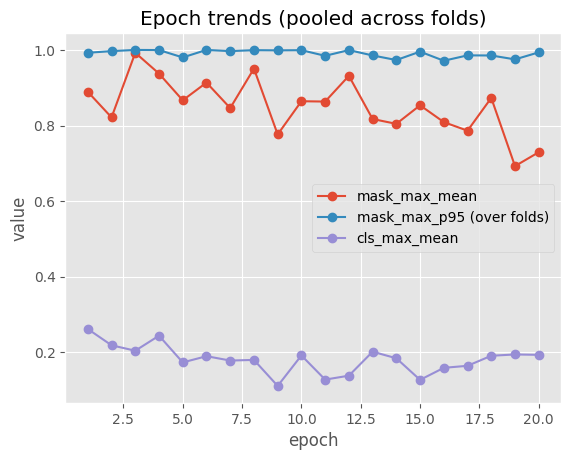

In [108]:
# --- Plots: mask_max_mean, mask_max_p95, cls_max_mean vs epoch ---

es_plot = epoch_summary.copy()

need = ["fold", "epoch", "mask_max_mean", "cls_max_mean"]
missing = [c for c in need if c not in es_plot.columns]
if missing:
    raise ValueError(f"epoch_summary missing required columns: {missing}")

# coerce numeric
for c in ["fold", "epoch", "mask_max_mean", "cls_max_mean"]:
    es_plot[c] = pd.to_numeric(es_plot[c], errors="coerce")

es_plot = es_plot.dropna(subset=["epoch", "mask_max_mean", "cls_max_mean"])

# aggregate across folds per epoch
g = es_plot.groupby("epoch", as_index=False).agg(
    mask_max_mean=("mask_max_mean", "mean"),
    mask_max_p95=("mask_max_mean", lambda s: s.quantile(0.95)),
    cls_max_mean=("cls_max_mean", "mean"),
)

plt.figure()
plt.plot(g["epoch"], g["mask_max_mean"], marker="o", label="mask_max_mean")
plt.plot(g["epoch"], g["mask_max_p95"], marker="o", label="mask_max_p95 (over folds)")
plt.plot(g["epoch"], g["cls_max_mean"], marker="o", label="cls_max_mean")
plt.xlabel("epoch")
plt.ylabel("value")
plt.title("Epoch trends (pooled across folds)")
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
# sanity_random_200 check

In [ ]:
csvs = sorted(SAMPLEDUMP_ROOT.rglob("sanity_random_200.csv"))
assert csvs, "No sanity_random_200.csv found under sanity_dumps"

df = pd.read_csv(csvs[-1])

summary = {
    "rows": len(df),
    "forged_folder_rate": df["is_forged_folder"].mean(),
    "image_label_rate": df["image_label"].mean(),
    "any_instances_rate": (df["num_instances"] > 0).mean(),
    "mean_union_sum": df["union_sum"].mean(),
    "mean_max_instance_sum": df["max_instance_sum"].mean(),
}

display(pd.Series(summary, name="value").to_frame())


,value
rows,200.000
forged_folder_rate,0.545
image_label_rate,0.545
any_instances_rate,0.545
mean_union_sum,30973.545
mean_max_instance_sum,26154.455


In [ ]:
# Cross-tab: are forged-folder images ever labeled authentic?
pd.crosstab(df["is_forged_folder"], df["image_label"])

image_label,0.0,1.0
is_forged_folder,,
False,91,0
True,0,109


In [ ]:
# How often do we have forged-folder but zero instances?
df.query("is_forged_folder == True and num_instances == 0").shape[0]

0